In [1]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table,Column
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit

In [2]:
#import sys
#sys.path.append("../") # go to parent dir
from functionzfolder import functionz as fz
import imp
imp.reload(fz)
fz.printit("test")

Did your bidding master


In [3]:
# Enter Source name = directory name, ra and dec in decimal degrees
myname = 'SerpNE'
myra = '279.50375'
mydec = '0.008278'
YSOcat = "SerpensNE-YSOs.tbl"
FullCat = "catalog-SerpensNE-FULL.tbl"
SDSSCat = "SDSS-NE.votable"


In [4]:
# set-up for query to GAIA archive
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Retrieving tables...
Parsing tables...
Done.
external.external.gaiadr2_geometric_distance
public.public.dual
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour
gaiadr1.gaiadr1.ppmxl_neighbourhood
gaiadr1.gaiadr1.sdss_dr9_best_neighbour
gaiadr1.gaiadr1.sdss_dr9_neighbourhood
gaiadr1.gaiadr1.tmass_best_neighbour
gaiadr1.gaiadr1.tmass_neighbourhood
gaiadr1.gaiadr1.ucac4

In [5]:
# send request to GAIA archive
# the items in the box command are (corrdinate system, RA in deg, Dec in deg, box width in RA and Dec in deg)
query = "SELECT * \
FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass \
WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid \
AND CONTAINS(POINT('ICRS',g.ra,g.dec),BOX('ICRS',myra,mydec,1.,1.))=1 ;"
query1 = query.replace('myra',myra)
query2 = query1.replace('mydec',mydec)
job1 = Gaia.launch_job_async(query2, dump_to_file=False)

Query finished.


In [6]:
# this retrieves the result from the query above and puts into a table with the name "p"
# The next line prints out the labels for all of the columns in the table
p = job1.get_results() 
print (p.colnames) 

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

In [7]:
# This assigns some of the columns in the table to specific variable names for further use in the notebook
# par = parallax, epar = error in parallax, pmra = proper motion in RA, pmdec = proper motion in Dec
# A_G = GAIA estimated extinction in G-band, Gmag = GAIA G-band mag, Kmag = 2MASS K-band mag,
# separ = seperation between GAIA and 2MASS source in arcsecs, Dist = distance in pc calculated from parallax
# This assigns some of the columns in the table to specific variable names for further use in the notebook
# par = parallax, epar = error in parallax, pmra = proper motion in RA, pmdec = proper motion in Dec
# A_G = GAIA estimated extinction in G-band, Gmag = GAIA G-band mag, Kmag = 2MASS K-band mag,
# separ = seperation between GAIA and 2MASS source in arcsecs, Dist = distance in pc calculated from parallax
ra = p["ra"]
dec = p["dec"]
par = p["parallax"]
epar = p["parallax_error"]
par_sn = par/epar
pmra = p["pmra"]
pmdec = p["pmdec"]
A_G = p["a_g_val"]
Gflux_bad = p["phot_g_mean_flux"]
GBflux_bad = p["phot_bp_mean_flux"]
GRflux_bad = p["phot_rp_mean_flux"]
Gflux_error = p["phot_g_mean_flux_error"]
GBflux_error = p["phot_bp_mean_flux_error"]
GRflux_error = p["phot_rp_mean_flux_error"]
Gsn = p["phot_g_mean_flux_over_error"]
GBsn = p["phot_bp_mean_flux_over_error"]
GRsn = p["phot_rp_mean_flux_over_error"]
Gmag = p["phot_g_mean_mag"]
GBmag = p["phot_bp_mean_mag"]
GRmag = p["phot_rp_mean_mag"]
Gflux = np.power(10,(Gmag/-2.5))*(2835.1e3)
GBflux = np.power(10,(GBmag/-2.5))*(3393.3e3)
GRflux = np.power(10,(GRmag/-2.5))*(2485.1e3)
Gmag_error = -2.5*(np.log(10))*((Gflux_error)/(Gflux_bad))
GBmag_error = -2.5*(np.log(10))*((GBflux_error)/(GBflux_bad))
GRmag_error = -2.5*(np.log(10))*((GRflux_error)/(GRflux_bad))
Kmag = p["ks_m"]
separ = p["angular_distance"]
Gaia2MASS = p["designation_2"]
Dist = 1000./par
print("Number of Sources: ",len(ra))

Number of Sources:  31475


Sources with Parallaxes with S/N > 5:  1288
        and with A_G measurements:  413
Sources with A_G measurements:  876


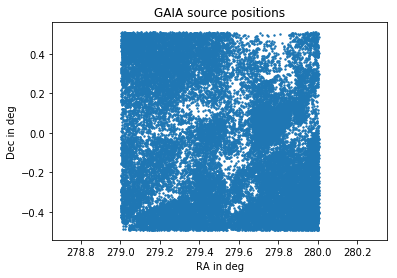

/n/algol2/mpound/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/n/algol2/mpound/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


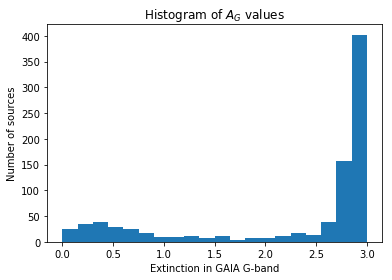

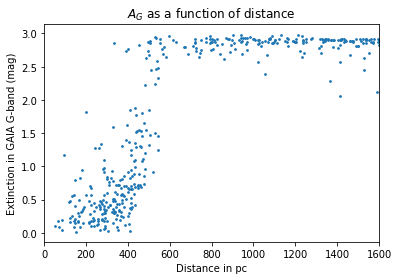

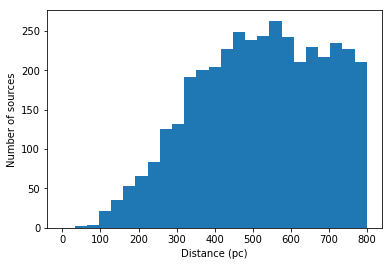

In [15]:
# find out the number of GAIA sources with parallaxes
# and the number of GAIA source with both parallax and A_G measurements in the catalog
# Then find the number of source in the GAIA catalog with A_G measurements (regardless of parallax)
# Then make some plots
npars = 0
navs = 0
for i in range(0,len(ra)):
    if(par_sn[i] > 5.0):
        npars = npars + 1
        if(A_G[i] > -0.1):
            navs = navs + 1
print("Sources with Parallaxes with S/N > 5: ", npars)
print("        and with A_G measurements: ",navs)
navs = 0
for i in range(0,len(ra)):
    if(A_G[i] > -0.1):
        navs = navs + 1
print("Sources with A_G measurements: ", navs)
plt.xlabel("RA in deg")
plt.ylabel("Dec in deg")
plt.axis("equal")
plt.title("GAIA source positions")
plt.scatter(ra,dec,s=2)
plt.show()
plt.xlabel("Extinction in GAIA G-band")
plt.ylabel("Number of sources")
plt.title("Histogram of $A_G$ values")
plt.hist(A_G,bins=20,range=(0,3))
#plt.show()
plt.savefig("SerpensNE_hist_A_G.png",dpi=300)
plt.show()
plt.title("$A_G$ as a function of distance")
plt.xlabel("Distance in pc")
plt.ylabel("Extinction in GAIA G-band (mag)")
plt.xlim(0,1600.)
plt.scatter(Dist,A_G,s=3)
plt.savefig("SerpensNE_Dist_A_G.png",dpi=300)
plt.show()
plt.hist(Dist,bins=25,range=(0.,800.))
plt.xlabel("Distance (pc)")
plt.ylabel("Number of sources")
plt.savefig("SerpensNE_hist_Dist.png",dpi=300)
plt.show()


In [95]:
# read in the YSO catalog from GB for core
# print out some things about each YSO and create a regions file for ds9 which puts a circle around each YSO
TabGB = Table.read(YSOcat, format="ascii.ipac")
print(Tabc2d.colnames)
GBra = TabGB["ra"]
GBdec = TabGB["dec"]
GBid = TabGB["GBS_ID"]
GB2mass = TabGB["id2mass"]
GBalph = TabGB["alpha"]
GBobj = TabGB["object_type"]
GBJflux = TabGB["J_flux_c"]
GBHflux = TabGB["H_flux_c"]
GBKflux = TabGB["Ks_flux_c"]
GBI1flux = TabGB["IR1_flux_c"]
GBI2flux = TabGB["IR2_flux_c"]
GBI3flux = TabGB["IR3_flux_c"]
GBI4flux = TabGB["IR4_flux_c"]
GBM1flux = TabGB["MP1_flux_c"]
GBM2flux = TabGB["MP2_flux_c"]
GBI1err = TabGB["IR1_D_flux_c"]
GBI2err = TabGB["IR2_D_flux_c"]
GBI3err = TabGB["IR3_D_flux_c"]
GBI4err = TabGB["IR4_D_flux_c"]
GBI1err = TabGB["MP1_D_flux_c"]
GBJmag = -2.5*np.log10(TabGB["J_flux_c"]/1594.0e3)
GBHmag = -2.5*np.log10(TabGB["H_flux_c"]/1024.0e3)
GBKmag = -2.5*np.log10(TabGB["Ks_flux_c"]/666.7e3)
GBI1mag = -2.5*np.log10(TabGB["IR1_flux_c"]/280.9e3)
GBI2mag = -2.5*np.log10(TabGB["IR2_flux_c"]/179.7e3)
GBI3mag = -2.5*np.log10(TabGB["IR3_flux_c"]/115.0e3)
GBI4mag = -2.5*np.log10(TabGB["IR4_flux_c"]/64.13e3)
GBMP1mag = -2.5*np.log10(TabGB["MP1_flux_c"]/7.14e3)
GBMP2mag = -2.5*np.log10(TabGB["MP2_flux_c"]/0.775e3)
print("Number of YSOs: ", len(GBra))

['GBS_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


GAIA Index numbers of GAIA-GB YSO matches:  [27942 21973 22119 28709 22255 20516 20916 12522 21954 11747 10723 10915
 23395 13514 14816 21832 20575 13766 13262 13569 17110 11926 14738 14978
 20215 16070 20033 13761 22443 22555 23339 12252 18634 20598 14976   331
 19545 16885   507 19094 11810 21006 13786 14286 26797 12415 26055    -2
    -2    -2    -2 13066    -2 23037  9047 21208 20357  2873  3200  3026
 15927 22991 13344 17218    -2 16904    -2 18770 20827 11951 17891   362
    -2 23428 30714    -2    -2  5520  5412  2796 30787 14627 15417 15773
  6068  8463 11316 22388  5684 30059 31247    -2  6406 24922    -2 30816
 16751 22166 30117 30759  9377 18485 30801 13616    -2    -2 31381 15831
    -2 12696   540 26080 27514 30662    -2 17938 26541 27626 28018    -2
 18415   187 27591 16047 11008 15117  4415    -2  9692 29515   637 16993
 15267  1101 24947    -2  3861 23800  9714 26563 23600    -2 29223 23690
  3671 29216    -2    -2  9649    -2  1077 24106  7713 26978 27924 27731
  8441 

SSTGBS J183853.4+000-418 YSOc_star+dust(MP1)  Parallax:  -0.399477897974  S/N:  -0.853295611505  Distance:  -2503.26740245  Separation: 0.184005918933
SSTGBS J183853.7+000045 YSOc_star+dust(MP1)  Parallax:  0.136041802437  S/N:  0.604136941225  Distance:  7350.68179109  Separation: 0.27776549119
SSTGBS J183854.4+000-2722 YSOc_star+dust(MP1)  Parallax:  0.184151540722  S/N:  0.756565975677  Distance:  5430.3102547  Separation: 0.0931067747542
SSTGBS J183855.7+001443 YSOc_star+dust(MP1)  Parallax:  0.101920486875  S/N:  0.85980679179  Distance:  9811.57008426  Separation: 0.0981481025025
SSTGBS J183857.9+000-1120 YSOc_star+dust(IR4)  Parallax:  0.144422231753  S/N:  0.323975432305  Distance:  6924.14171879  Separation: 0.068924175126
SSTGBS J183859.6+000458 YSOc_star+dust(MP1)  Parallax:  -0.800298850386  S/N:  -2.87830358758  Distance:  -1249.53322064  Separation: 0.0755398350782
SSTGBS J183859.9+000-810 YSOc_star+dust(MP1)  Parallax:  0.469476139559  S/N:  1.49909218035  Distance:  213

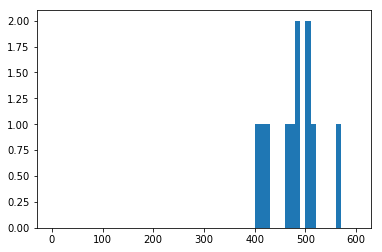

In [16]:
# Match up the GAIA and GB YSOs based on the 2MASS cross identifications within each of the catalogs
# Print out the parallax, S/N on parallax, and distance for each YSO with parallax
# calculate the average distance based on parallaxes with S/N>10
# If there are no YSOs with great parallaxes, print out a little info about the YSOs
cross_match = np.empty(len(GB2mass),dtype=int); cross_match.fill(-2)
gaia_list = []
for i in range(0,len(Gaia2MASS)):
    gaia_list.append(Gaia2MASS[i].decode('utf-8'))
for j in range(0,len(GB2mass)):
    if(GB2mass[j] in gaia_list):
        cross_match[j] = gaia_list.index(GB2mass[j])
    else:
        cross_match[j] = -2

print("GAIA Index numbers of GAIA-GB YSO matches: ",cross_match)
avg = 0.
navg = 0
for m in range(0,len(GB2mass)):    
    if(cross_match[m] > -1):
        r = cross_match[m]
        print(GBid[m],GBobj[m]," Parallax: ", par[r]," S/N: ",par_sn[r]," Distance: ",Dist[r]," Separation:",separ[r])
        if(par_sn[r] > 10.):
            navg = navg + 1
            avg = avg + Dist[r]
if(navg > 0):
    avg = avg/navg
    print("Average distance: ",avg, " based on ", navg, " sources" )
if(navg < 1):
    print("No sources with sufficient S/N to get distance ")
    for m in range(0,len(id2mass)):
        if(cross_match[m] > -1):
            n = cross_match[m]
            print(GBid[m],c2dobj[m], " G and K mags: ",Gmag[n],Kmag[n], "GAIA-2MASS Separation: ", separ[n])
gooddis = np.zeros(navg)
ngood = 0
for m in range(0,len(GB2mass)):
        if(cross_match[m] > -1 ):
            n = cross_match[m]
            if(par_sn[n] > 10.):
                gooddis[ngood] = Dist[n]
                ngood = ngood + 1
plt.hist(gooddis,bins=60,range=(0,600))
plt.show()

In [71]:
TabSDSS = Table.read("SDSS.csv", format="ascii.csv")
print(TabSDSS.colnames)
SDSSra = TabSDSS["ra"]
SDSSdec = TabSDSS["dec"]
SDSSid = TabSDSS["objid"]
umag = TabSDSS["u"]
umage = TabSDSS["Err_u"]
gmag = TabSDSS["g"]
gmage = TabSDSS["Err_g"]
rmag = TabSDSS["r"]
rmage = TabSDSS["Err_r"]
imag = TabSDSS["i"]
image = TabSDSS["Err_i"]
zmag = TabSDSS["z"]
zmage = TabSDSS["Err_z"]

print("Number of SDSS sources: ",len(SDSSra) )

['objid', 'run', 'rerun', 'camcol', 'field', 'obj', 'type', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'Err_u', 'Err_g', 'Err_r', 'Err_i', 'Err_z']
Number of SDSS sources:  114065


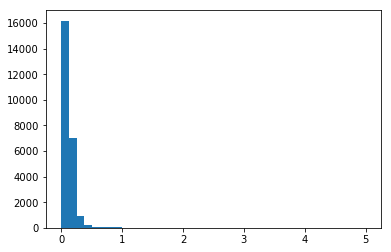

24314


In [52]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ra, dec=dec, unit=(u.degree,u.degree))  
catalog = SkyCoord(ra=SDSSra, dec=SDSSdec, unit=(u.degree,u.degree))  
GAIA_SDSS_idx, d2d, d3d = c.match_to_catalog_sky(catalog) 
GAIA_SDSS_dasec = d2d.to(u.arcsec).value
plt.hist(GAIA_SDSS_dasec,bins=40,range=(0.,5.))
plt.show()
nn = 0
for i in range(0,len(GAIA_SDSS_dasec)):
    if(GAIA_SDSS_dasec[i] < 0.5):
        nn = nn + 1
print(nn)

In [138]:
TabGBFull = Table.read(FullCat, format="ascii.ipac")
Full_ra = TabGBFull["ra"]
Full_dec = TabGBFull["dec"]
Full_id = TabGBFull["GBS_ID"]
Full2mass = TabGBFull["id2mass"]
Fullalph = TabGBFull["alpha"]
FullAv = TabGBFull["Av"]
FullAverr = TabGBFull["D_Av"]
Fullobj = TabGBFull["object_type"]
FullI1flux = TabGBFull["IR1_flux_c"]
FullI2flux = TabGBFull["IR2_flux_c"]
FullI3flux = TabGBFull["IR3_flux_c"]
FullI4flux = TabGBFull["IR4_flux_c"]
FullM1flux = TabGBFull["MP1_flux_c"]
FullI1err = TabGBFull["IR1_D_flux_c"]
FullI2err = TabGBFull["IR2_D_flux_c"]
FullI3err = TabGBFull["IR3_D_flux_c"]
FullI4err = TabGBFull["IR4_D_flux_c"]
FullMP1err = TabGBFull["MP1_D_flux_c"]
print("Number of GB sources: ", len(Full_ra))

Number of GB sources:  339449


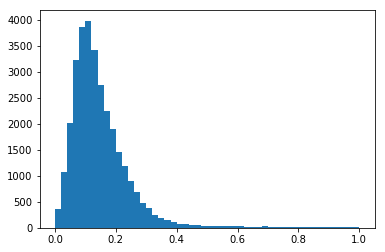

30926


In [59]:
c_full = SkyCoord(ra=Full_ra, dec=Full_dec, unit=(u.degree,u.degree))  
GAIA_GB_idx, d2d, d3d = c.match_to_catalog_sky(c_full) 
GAIA_GB_dasec = d2d.to(u.arcsec).value
plt.hist(GAIA_GB_dasec,bins=50,range=(0.,1.))
plt.show()
nn = 0
for i in range(0,len(GAIA_GB_dasec)):
    if(GAIA_GB_dasec[i] < 0.5):
        nn = nn + 1
print(nn)

In [66]:
ntriple = 0
triple = np.empty(len(ra),dtype=bool)
for i in range(len(GAIA_GB_idx)):
    if(GAIA_GB_dasec[i] > 0.5):
        GAIA_GB_idx[i] = -2
    if(GAIA_SDSS_dasec[i] > 0.5):
        GAIA_SDSS_idx[i] = -2
    if(GAIA_GB_idx[i] > 0 and GAIA_SDSS_idx[i] > 0):
        ntriple = ntriple + 1
        triple[i] = True
    else:
        triple[i] = False
print("Number of Sources in GAIA+SDSS+GB: ",ntriple)

Number of Sources in GAIA+SDSS+GB:  24093


In [139]:
TabCat = Table([p["source_id"],p["ra"],p["dec"],p["parallax"],p["parallax_over_error"],p['a_g_val'],p['a_g_percentile_lower'],p['a_g_percentile_upper'],p["phot_g_mean_mag"],p["phot_g_mean_flux"],p["phot_g_mean_flux_error"],p["phot_bp_mean_mag"],p["phot_bp_mean_flux"],p["phot_bp_mean_flux_error"],p["phot_rp_mean_mag"],p["phot_rp_mean_flux"],p["phot_rp_mean_flux_error"],p["j_m"],p["j_msigcom"],p["h_m"],p["h_msigcom"],p["ks_m"],p["ks_msigcom"]])

In [140]:
TabCat["source_id"].dtype=np.int
wumag = np.empty(len(GAIA_SDSS_idx),dtype=float)
wumage = np.empty(len(GAIA_SDSS_idx),dtype=float)
wgmag = np.empty(len(GAIA_SDSS_idx),dtype=float)
wgmage = np.empty(len(GAIA_SDSS_idx),dtype=float)
wrmag = np.empty(len(GAIA_SDSS_idx),dtype=float)
wrmage = np.empty(len(GAIA_SDSS_idx),dtype=float)
wimag = np.empty(len(GAIA_SDSS_idx),dtype=float)
wimage = np.empty(len(GAIA_SDSS_idx),dtype=float)
wzmag = np.empty(len(GAIA_SDSS_idx),dtype=float)
wzmage = np.empty(len(GAIA_SDSS_idx),dtype=float)
wSDSSid = np.empty(len(GAIA_SDSS_idx),dtype=np.object)
for i in range(0,len(GAIA_SDSS_idx)):
    if(triple[i]):
        j = int(GAIA_SDSS_idx[i])
        wSDSSid[i] = SDSSid[j]
        wumag[i] = umag[j]
        wumage[i] = umage[j]
        wgmag[i] = gmag[j]
        wgmage[i] = gmage[j]
        wrmag[i] = rmag[j]
        wrmage[i] = rmage[j]
        wimag[i] = imag[j]
        wimage[i] = image[j]
        wzmag[i] = zmag[j]
        wzmage[i] = zmage[j]
TabCat['SDSS_id'] = Column(data=wSDSSid,dtype=np.object)
TabCat['u_SDSS'] = Column(data=wumag,dtype=float,unit="mag")
TabCat['u_SDSS_err'] = Column(data=wumage,dtype=float,unit="mag")
TabCat['g_SDSS'] = Column(data=wgmag,dtype=float,unit="mag")
TabCat['g_SDSS_err'] = Column(data=wgmage,dtype=float,unit="mag")
TabCat['r_SDSS'] = Column(data=wrmag,dtype=float,unit="mag")
TabCat['r_SDSS_err'] = Column(data=wrmage,dtype=float,unit="mag")
TabCat['i_SDSS'] = Column(data=wimag,dtype=float,unit="mag")
TabCat['i_SDSS_err'] = Column(data=wimage,dtype=float,unit="mag")
TabCat['z_SDSS'] = Column(data=wzmag,dtype=float,unit="mag")
TabCat['z_SDSS_err'] = Column(data=wzmage,dtype=float,unit="mag")

wGBid = np.empty(len(GAIA_SDSS_idx),dtype=np.object)
wGBobj = np.empty(len(GAIA_SDSS_idx),dtype=np.object)
wGBalph = np.empty(len(GAIA_SDSS_idx),dtype=float)
wAv = np.empty(len(GAIA_SDSS_idx),dtype=float)
wAve = np.empty(len(GAIA_SDSS_idx),dtype=float)
i1flux = np.empty(len(GAIA_SDSS_idx),dtype=float)
i1err = np.empty(len(GAIA_SDSS_idx),dtype=float)
i2flux = np.empty(len(GAIA_SDSS_idx),dtype=float)
i2err = np.empty(len(GAIA_SDSS_idx),dtype=float)
i3flux = np.empty(len(GAIA_SDSS_idx),dtype=float)
i3err = np.empty(len(GAIA_SDSS_idx),dtype=float)
i4flux = np.empty(len(GAIA_SDSS_idx),dtype=float)
i4err = np.empty(len(GAIA_SDSS_idx),dtype=float)
m1flux = np.empty(len(GAIA_SDSS_idx),dtype=float)
m1err = np.empty(len(GAIA_SDSS_idx),dtype=float)
for i in range(0,len(GAIA_GB_idx)):
    if(triple[i]):
        j = GAIA_GB_idx[i]
        wGBid[i] = Full_id[j]
        wGBobj[i] = Fullobj[j]
        wGBalph[i] = Fullalph[j]
        wAv[i] = FullAv[j]
        wAve[i] = FullAverr[j]
        i1flux[i] = FullI1flux[j]
        i1err[i] = FullI1err[j]
        i2flux[i] = FullI2flux[j]
        i2err[i] = FullI2err[j]
        i3flux[i] = FullI3flux[j]
        i3err[i] = FullI3err[j]
        i4flux[i] = FullI4flux[j]
        i4err[i] = FullI4err[j]
        m1flux[i] = FullM1flux[j]
        m1err[i] = FullMP1err[j]
TabCat['GB_id'] = Column(data=wGBid,dtype=np.object)
TabCat['GB_object'] = Column(data=wGBobj,dtype=np.object)
TabCat['GB_alpha'] = Column(data=wGBalph,dtype=float)
TabCat['GB_Av'] = Column(data=wAv,dtype=float)
TabCat['GB_Av_err'] = Column(data=wAve,dtype=float)
TabCat['I1_flux'] = Column(data=i1flux,dtype=float,unit="mJy")
TabCat['I1_flux_err'] = Column(data=i1err,dtype=float,unit="mJy")
TabCat['I2_flux'] = Column(data=i2flux,dtype=float,unit="mJy")
TabCat['I2_flux_err'] = Column(data=i2err,dtype=float,unit="mJy")
TabCat['I3_flux'] = Column(data=i3flux,dtype=float,unit="mJy")
TabCat['I3_flux_err'] = Column(data=i3err,dtype=float,unit="mJy")
TabCat['I4_flux'] = Column(data=i4flux,dtype=float,unit="mJy")
TabCat['I4_flux_err'] = Column(data=i4err,dtype=float,unit="mJy")
TabCat['M1_flux'] = Column(data=m1flux,dtype=float,unit="mJy")
TabCat['M1_flux_err'] = Column(data=m1err,dtype=float,unit="mJy")
TabCat['All_data_flag'] = Column(data=triple,dtype=bool)

In [141]:
print(TabCat.colnames)

['source_id', 'ra', 'dec', 'parallax', 'parallax_over_error', 'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper', 'phot_g_mean_mag', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'j_m', 'j_msigcom', 'h_m', 'h_msigcom', 'ks_m', 'ks_msigcom', 'SDSS_id', 'u_SDSS', 'u_SDSS_err', 'g_SDSS', 'g_SDSS_err', 'r_SDSS', 'r_SDSS_err', 'i_SDSS', 'i_SDSS_err', 'z_SDSS', 'z_SDSS_err', 'GB_id', 'GB_object', 'GB_alpha', 'GB_Av', 'GB_Av_err', 'I1_flux', 'I1_flux_err', 'I2_flux', 'I2_flux_err', 'I3_flux', 'I3_flux_err', 'I4_flux', 'I4_flux_err', 'M1_flux', 'M1_flux_err', 'All_data_flag']


In [142]:
from astropy.io.votable import from_table, writeto
votable = from_table(TabCat)
writeto(votable, "GAIA_SDSS_GB.votable")
print("VO table written")

VO table written


In [143]:
Tabtest = Table.read("GAIA_SDSS_GB.votable", format="votable")
print("VO table read into notebook")

VO table read into notebook


In [144]:
print(Tabtest.colnames)

['source_id', 'ra', 'dec', 'parallax', 'parallax_over_error', 'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper', 'phot_g_mean_mag', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'j_m', 'j_msigcom', 'h_m', 'h_msigcom', 'ks_m', 'ks_msigcom', 'SDSS_id', 'u_SDSS', 'u_SDSS_err', 'g_SDSS', 'g_SDSS_err', 'r_SDSS', 'r_SDSS_err', 'i_SDSS', 'i_SDSS_err', 'z_SDSS', 'z_SDSS_err', 'GB_id', 'GB_object', 'GB_alpha', 'GB_Av', 'GB_Av_err', 'I1_flux', 'I1_flux_err', 'I2_flux', 'I2_flux_err', 'I3_flux', 'I3_flux_err', 'I4_flux', 'I4_flux_err', 'M1_flux', 'M1_flux_err', 'All_data_flag']


In [146]:
Tabtest[20:35]

source_id,ra,dec,parallax,parallax_over_error,a_g_val,a_g_percentile_lower,a_g_percentile_upper,phot_g_mean_mag,phot_g_mean_flux,phot_g_mean_flux_error,phot_bp_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_rp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,SDSS_id,u_SDSS,u_SDSS_err,g_SDSS,g_SDSS_err,r_SDSS,r_SDSS_err,i_SDSS,i_SDSS_err,z_SDSS,z_SDSS_err,GB_id,GB_object,GB_alpha,GB_Av,GB_Av_err,I1_flux,I1_flux_err,I2_flux,I2_flux_err,I3_flux,I3_flux_err,I4_flux,I4_flux_err,M1_flux,M1_flux_err,All_data_flag
,deg,deg,mas,,mag,mag,mag,mag,'electron'.s**-1,'electron'.s**-1,mag,'electron'.s**-1,'electron'.s**-1,mag,'electron'.s**-1,'electron'.s**-1,mag,mag,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,
int64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
4273397665301360512,279.02240971330588,0.50420645572677192,0.68063798263992337,2.9242098,--,--,--,17.503117,1879.748466686377,2.7693353710447779,19.360819,249.01619304492209,8.0369397577910728,16.179777,2709.2980013652304,13.932130491646216,13.751,0.025,12.772,0.027000001,12.413,0.028000001,None,6.9029356264615028e-310,1.0228422234029641e-143,6.9031055837111277e-310,6.9031044758034521e-310,0.0,6.9031053211790208e-310,--,-0.066661811924241629,4.8537270434874283e-273,6.9031074955963152e-310,None,None,6.8946584422481867e-15,6.9030273734539229e-310,6.902690086290344e-310,4.1145026519816933e-315,0.018827719999999999,3.4826585533104438e+174,6.9028529524115524e-310,6.9031044758034521e-310,2.2175510492125846e-296,6.9031053729025557e-310,2.2471174879937118e+307,340.65769840803739,22.942716846605727,False
4273397630941621248,279.01183810380911,0.49445789973308779,0.28633657378322885,1.3858283,--,--,--,17.439108,1993.8988049745583,2.5645697240901804,19.403358,239.44850590344316,6.9046509864127747,16.096584,2925.0550700179319,11.160526312807352,13.543,0.030999999,12.466,0.028000001,12.095,0.028999999,None,6.9029356267943054e-310,2.825843801635982e-306,0.0,6.9031044758034521e-310,0.0,6.9031053211790208e-310,15.40788532012353,-0.011351048727820405,9.3737348314092851e-307,6.9031055816555676e-310,None,None,-7.2966211900119336e-233,6.903027373461828e-310,6.902690086290344e-310,4.1145223355570237e-315,0.016419679999999999,5.3821462965154973e+228,6.9028529524115524e-310,6.9031044758034521e-310,1.1307063065844666e-282,6.9031053729025557e-310,2.2471174879937118e+307,242.28422703941536,26.950727578484965,False
4273397626646576384,279.00942492524337,0.48863649011587668,1.5972973833140209,0.9670617,--,--,--,20.618731,106.62385092199932,1.2799538605582059,21.923496,23.504822057141769,7.5573563466257951,19.267805,157.63254267577625,13.390647296226152,16.358999,--,15.628,0.148,15.373,0.17299999,None,6.9029356273377776e-310,-1.4672619900774975e-272,2.4703282292062327e-323,6.9031044758034521e-310,0.0,6.9031053211790208e-310,13.312779033936513,-0.2388592466460992,2.2194150881808094e-301,6.9031055815773076e-310,None,None,6.9028535430480599e-310,6.903027373469733e-310,6.902690086290344e-310,4.114542019132354e-315,0.02427487,2.0669809644215024e+161,6.9028529524115524e-310,6.9031044758034521e-310,5.8413217715539183e-302,6.9031053729025557e-310,61101768.193477668,227.76417153339696,12.715310796293748,False
4273397729726060160,279.00790529790652,0.50779375148701356,-1.5914657094951821,-1.4576238,--,--,--,19.927631,201.50861221034211,1.2763220272962956,21.215096,45.135349930071406,4.5464366066893378,18.653248,277.63180505900698,10.094454985441054,16.093,0.1,13.91,--,13.691,--,None,6.9029356274678157e-310,3.8917369261943586e-285,6.9028523080100802e-310,6.9031044758034521e-310,0

In [136]:
j_err = p["j_msigcom"]
print(j_err[10:15])

 j_msigcom 
    mag    
-----------
 0.15700001
0.030999999
      0.123
         --
0.032000002
